# Cavity Flow Problem

The problem to be simulated here is the flow of water in a small, square cavity, with a constantly flowing current just above it. This situation occurs in reality when we have a flow, for example a river, going over uneven ground. Because of this, we will define the top, or "lid" of the simulation to have a constant flow.


We complete this using the predictor-corrector step model. In this model, we calculate a starred velocity without the influence of pressure, in the explicit predictor step. This starred velocity is then used to calculate the next values of pressure, using the pressure poisson equation. Finally, we use the implicit corrector step to calculate the true next velocity, using the starred velocities and the pressure.

This method represents a mixture between that of Professor Lorena Barba, in the [12-steps to Navier Stokes](https://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/), and Mark Owkes' [A guide to writing your first CFD solver](https://www.montana.edu/mowkes/research/source-codes/GuideToCFD_2020_02_28_v2.pdf).

## Import Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Define Meshes and Storage Grids

In this section, we create meshes for storage of the velocities and pressure, and define the ranges of these meshes. These are defined conditions in the problem, so we can define them as we like. In this particular case, we are using a 40x40 mesh, with the points situated between 0 and 2 on both the x and y axes.

In [2]:
#X mesh, with 41 total points representing 40 divisions
nx = 41
x_min, x_max = 0, 2

#Y mesh, again 41 total points representing 40 divisions
ny = 41
y_min, y_max = 0, 2

#Find the difference in x and y between points on the grid
dx = (x_max - x_min)/ (nx-1)
dy = (y_max - y_min)/ (ny-1)

#Create blank storage grids for x-velocity, y-velocity, and pressure
u = np.zeros((ny, nx))
v = np.zeros((ny, nx))
p = np.zeros((ny, nx))

## Define Boundary Conditions

Here is where we define our boundary conditions, that do not change over the time-frame of the simulation. The two possible options here are "Dirichlet", where the velocities and pressure are fixed at the boundary, or "Neumann", where the value of the derivative is fixed at the boundary.

In this case, we are using Dirichlet boundary conditions for the velocities, and a mixture of Dirichlet and Neumann boundary conditions for the pressure.

The x-velocity has boundary conditions of 0 on the sides and bottom, and a value of 1 on the top, or lid. This is to represent the flow above the cavity. The y-velocity is set to 0 on all boundaries.

The pressure has its derivative with respect to x set to 0 on the sides, and the derivative with respect to y set to 0 on the bottom. The pressure is set to 0 (fixed) at y = 2.

In [3]:
#Setting velocity boundaries

def set_velocity_boundary(u, v):
    #Set u boundary conditions
    u[0, :]  = 0
    u[:, 0]  = 0
    u[:, -1] = 0 
    u[-1, :] = 1 #The lid has x-velocity of 1 for the flow on top of the cavity

    #Set v boundary conditions
    v[0, :]  = 0
    v[:, 0]  = 0
    v[:, -1] = 0 
    v[-1, :] = 0
    
    return u, v

u, v = set_velocity_boundary(u, v)

#Pressure boundary conditions
# We make a function for this as we have to keep the derivative constant
# This means changing values some of the time

def set_pressure_boundary(p):
    #Neumann conditions
    p[:, -1] = p[:, -2] #This makes dp/dx = 0 at x = 2
    p[0, :] = p[1, :]   #This makes dp/dy = 0 at y = 0
    p[:, 0] = p[:, 1]   #This makes dp/dx = 0 at x = 0

    #Dirichlet Condition
    p[-1, :] = 0
    
    return p
    
p = set_pressure_boundary(p)

## Discretisation with Finite Difference Functions

As we have to do the finite difference method many times in order to update our equations, we can create functions for these, in order to make the code more readable and less repetitive.

In [4]:
#The first difference approximates the derivative with respect to y or x
# At the given point. We do this for the whole array at once

def diff_1st_x(f,dx):
    return (f[1:-1, 2:] - f[1:-1,0:-2])/(2*dx)

def diff_1st_y(f,dy):
    return (f[2:, 1:-1] - f[0:-2,1:-1])/(2*dy)


#The second difference approximates the second derivative
# with respect to x or y
def diff_2nd_x(f,dx):
    # f(i-1,j) + 2*f(i,j) + f(i+1,j) 
    return ((f[1:-1,0:-2] - 2*f[1:-1,1:-1] + f[1:-1,2:]) / dx**2) 
  
def diff_2nd_y(f,dy):
    # f(i,j-1) + 2*f(i,j) + f(i,j+1) 
    return ((f[0:-2,1:-1] - 2*f[1:-1,1:-1] + f[2:,1:-1]) / dy**2)


#A laplacian is defined as the sum of the second differences
# with respect to x and y
def laplacian(f, dx, dy):
    return (diff_2nd_x(f, dx) + 
            diff_2nd_y(f, dy))

## Computing Starred Velocities

In this step, we perform the predictor-step to calculate the starred velocities. This is using the following equation, from Owkes (2020):

$$ u^* = u^n + \Delta t (\nu (\nabla^{2}u^n) - (u^n \frac{\delta u^n}{\delta x} + v^n \frac{\delta u^n}{\delta y}))$$

$$ v^* = v^n + \Delta t (\nu (\nabla^{2}v^n) - (u^n \frac{\delta v^n}{\delta x} + v^n \frac{\delta v^n}{\delta y}))$$

In these equations, $\nu$ represents the viscosity term.

In [5]:
def get_starred_velocities(un, vn, dx, dy, dt, vis):
    #Create copies for new values to be calculated in
    u_star = u.copy()
    v_star = v.copy()
    
    #Compute u_star
    u_star[1:-1,1:-1] = (vis * laplacian(un, dx, dy) -
                         (un[1:-1, 1:-1]*diff_1st_x(un,dx) + 
                          vn[1:-1, 1:-1]*diff_1st_y(un,dy))
                          )*dt + un[1:-1, 1:-1]
    
    #Compute v_star
    v_star[1:-1,1:-1] = (vis * laplacian(vn, dx, dy) -
                         (un[1:-1, 1:-1]*diff_1st_x(vn,dx) + 
                          vn[1:-1, 1:-1]*diff_1st_y(vn,dy))
                          )*dt + vn[1:-1, 1:-1]
    
    
    return u_star, v_star

## Computing the Pressure with the Pressure-Poisson Equation

Here, we calculate the pressure at the next step, using these starred velocities. The equations for this are long and complicated.....

We start with defining a term b, that will be used to simplify later equations

In [6]:
#Define b term to make later calculation easier
def get_b(u_star, v_star, dx, dy, dt):
    divergence_vel_star = (diff_1st_x(u_star, dx) +
                           diff_1st_y(v_star, dy))
    
    b = (rho / dt) * divergence_vel_star
    
    return b

In [7]:
#Define pressure-poisson equation solver

#Note that we don't need dt for this, as we are not
# advancing in time during this process

def pressure_poisson(p, b, dx, dy):
    pn = p.copy()
    
    
    #We split this equation into 3 terms to make it more readable
    term1 = (pn[1:-1,0:-2] + pn[1:-1,2:]) * dy**2
    
    term2 = (pn[0:-2,1:-1] + pn[2:,1:-1]) * dx**2
    
    term3 = -(b * (dx**2 * dy**2))
    
    #Now, we finally calculate the new pressures:
    p[1:-1, 1:-1] = (
        (term1 + term2 + term3) / (2*(dx**2 + dy**2))
    )
    
    #We then reset the boundary condition, as these are Neumann boundaries
    p = set_pressure_boundary(p)
    
    return p

## Corrector Step

Lastly, we perform the corrector step, which gives us the velocities at the next time-step

In [8]:
def corrector_step(u_star, v_star, p, dx, dy, dt, rho):
    u = u_star.copy()
    v = v_star.copy()
    
    u[1:-1, 1:-1] = (-dt/rho) * (diff_1st_x(p, dx)) + u_star[1:-1,1:-1]
    v[1:-1, 1:-1] = (-dt/rho)*(diff_1st_y(p, dy)) + v_star[1:-1,1:-1]
    
    #Optional check to make sure that boundary conditions are satisfied
    # this is more relevant when using Neumann boundaries
    
    u, v = set_velocity_boundary(u,v)
    
    return u, v

## Full Simulation

We can then construct our function to perform the whole simulation

We define the parameters and run

In [9]:
def cavity_flow(steps, u, v, p, dt, dx, dy, rho, vis):
    
    for _ in range(steps):
        un = u.copy()
        vn = v.copy()
        
        #Predictor step
        u_star, v_star = get_starred_velocities(un, vn, dx, dy, dt, vis)
        
        #Solve for next pressure
        b = get_b(u_star, v_star, dx, dy, dt)
        p = pressure_poisson(p, b, dx, dy)
        
        #Corrector step
        u, v = corrector_step(u_star, v_star, p, dx, dy, dt, rho)
        
    return u, v, p

In [10]:
#Define parameters

rho = 1 # density
vis = .1 # viscosity coefficient
dt = .001 # timestep

u, v, p = cavity_flow(1000, u, v, p, dt, dx, dy, rho, vis)

## Display Results

We can display both a quiver plot and a stream plot

In [11]:
x = np.linspace(x_min, x_max, nx)
y = np.linspace(y_min, x_max, ny)
X, Y = np.meshgrid(x,y)

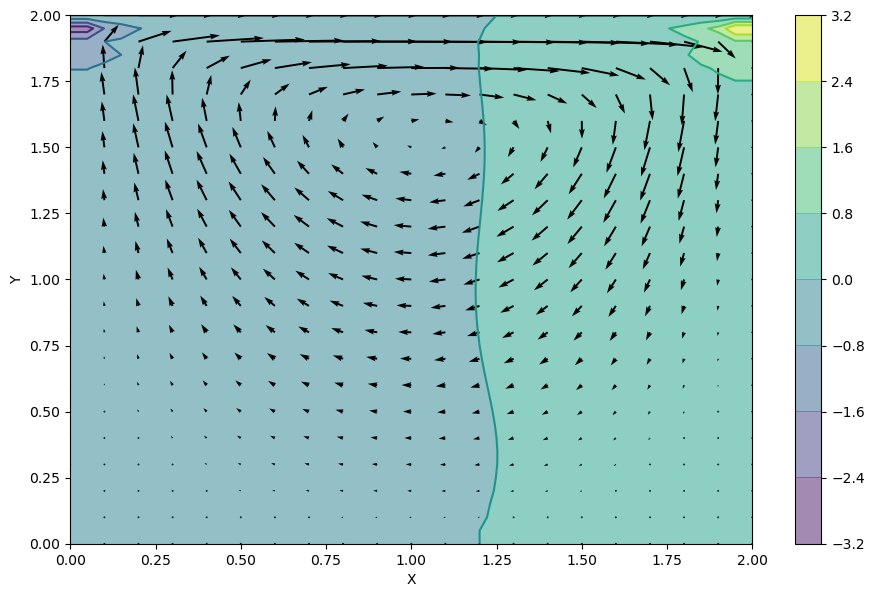

In [12]:
#Quiver plot

fig = plt.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
# plotting the pressure field outlines
plt.contour(X, Y, p, cmap=cm.viridis)
# plotting velocity field
plt.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2])
plt.xlabel('X')
plt.ylabel('Y');

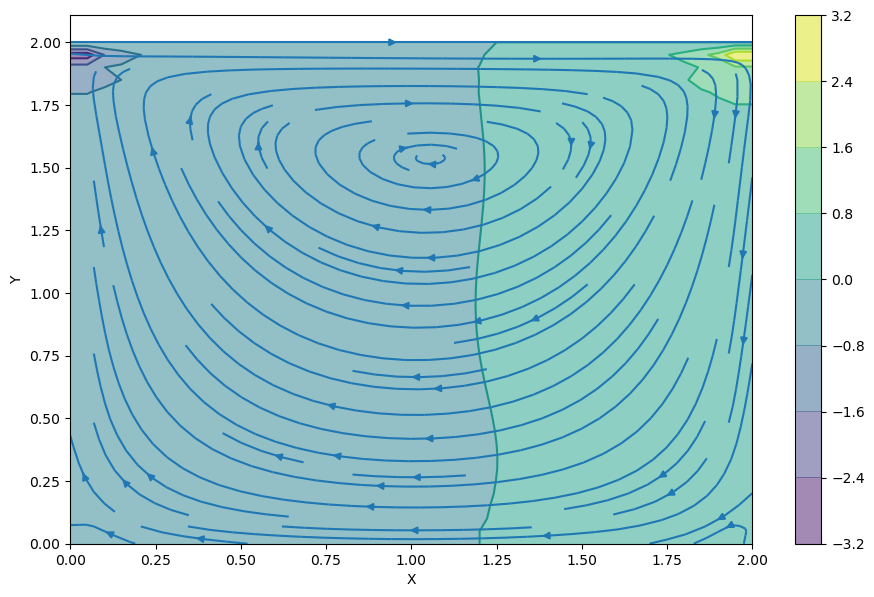

In [13]:
#Stream Plot

fig = plt.figure(figsize=(11, 7), dpi=100)
plt.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)
plt.colorbar()
plt.contour(X, Y, p, cmap=cm.viridis)
plt.streamplot(X, Y, u, v)
plt.xlabel('X')
plt.ylabel('Y');